In [49]:
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn import tree
from sklearn.preprocessing import LabelEncoder


In [2]:

df = pd.read_csv(r"D:\total_data.csv", index_col=False, usecols=['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'price', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'month', 'security_deposit','cleaning_fee'])

C:\Users\HK\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (33,54) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
df.head


<bound method NDFrame.head of        host_is_superhost host_listings_count   latitude  longitude  \
0                      f                   2 -22.965919 -43.178962   
1                      f                   1 -22.985698 -43.201935   
2                      f                   3 -22.977117 -43.190454   
3                      t                   1 -22.983024 -43.214270   
4                      f                   1 -22.988165 -43.193588   
...                  ...                 ...        ...        ...   
784117                 f                   0 -22.982870 -43.220140   
784118                 f                   2 -22.977930 -43.189500   
784119                 f                   1 -22.925610 -43.361750   
784120                 t                  54 -22.952230 -43.183550   
784121                 f                   4 -22.970050 -43.187690   

       property_type accommodates  bathrooms  bedrooms  beds  \
0        Condominium            5        1.0       2.0   2.0   
1

In [4]:
print(f'Rows: {df.shape[0]}, Columns: {df.shape[1]}')


Rows: 784122, Columns: 16


In [5]:
df.isnull().sum()

host_is_superhost                      386
host_listings_count                    386
latitude                                 1
longitude                                1
property_type                            1
accommodates                             1
bathrooms                             1494
bedrooms                               776
beds                                  2335
amenities                                1
price                                    1
security_deposit                    361064
cleaning_fee                        269336
require_guest_profile_picture            2
require_guest_phone_verification         2
month                                    2
dtype: int64

In [6]:
rows_before_drop = df.shape[0]
df.drop(['security_deposit','cleaning_fee','require_guest_phone_verification','require_guest_profile_picture','latitude','longitude','host_is_superhost'], axis=1, inplace=True)

#The colums Security_deposit and Cleaning_fee have a lot of null value and less significanct(Probably!) to our Decision Tree model. 

In [7]:
df.dropna(inplace=True)
df.isnull().sum()

host_listings_count    0
property_type          0
accommodates           0
bathrooms              0
bedrooms               0
beds                   0
amenities              0
price                  0
month                  0
dtype: int64

In [8]:
df.dtypes

host_listings_count     object
property_type           object
accommodates            object
bathrooms              float64
bedrooms               float64
beds                   float64
amenities               object
price                   object
month                  float64
dtype: object

As we can see the host_listing_count, accommodates and the price column which are generally either of the integer or float data type has an Object datatype. It is essential we typecast it to the integer datatype. In addition the Price would also have values like : '$200' '2,00,0000' which needs to be converted into a numeric string which would definitely improve the accuracy of the problem. 

In [9]:
df['host_listings_count'] = df['host_listings_count'].astype(np.float32, copy=False)
df['host_listings_count'] = df['host_listings_count'].astype(np.int16, copy=False)
df['accommodates'] = df['accommodates'].astype(np.int16, copy=False)
df['price'] = df['price'].str.replace('$', '', regex=False)
df['price'] = df['price'].str.replace(',', '', regex=False)
df['price'] = df['price'].astype(np.float32, copy=False)
df['price'] = df['price'].astype(np.int32, copy=False)
df['month'] = df['month'].astype(np.int32, copy=False)
df.dtypes

host_listings_count      int16
property_type           object
accommodates             int16
bathrooms              float64
bedrooms               float64
beds                   float64
amenities               object
price                    int32
month                    int32
dtype: object

In [10]:
def outlier_limit(column):
    qt = df[column].quantile([0.25,0.75])
    upper = qt.values[1]
    inter_quartile = upper-qt.values[0]
    limit = upper + 1.5*(inter_quartile)
    return limit

outlier_limit('price')

1274.5

In [13]:
def box_plot(column):
    fig, (ax1, ax2) = plt.subplots(1,2)
    fig.set_size_inches(16,6)
    _ = sns.boxplot(x=df[column], ax = ax1)
    ax1.set_title(f'{column} boxplot')
    ax2.set_title(f'Zooming in the {column} boxplot')
    ax2.set_xlim((-0.1,1.1*outlier_limit(column)))
    _ = sns.boxplot(x=df[column], ax = ax2)

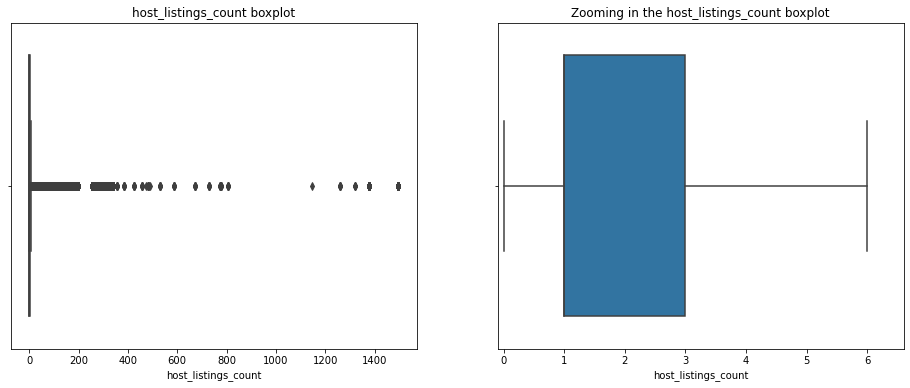

In [14]:
column = 'host_listings_count'
box_plot(column)

In [15]:
pd.set_option('mode.chained_assignment', None)
df = df[df['host_listings_count'] <= outlier_limit('host_listings_count')]
df.loc[df['host_listings_count'] == 0.0, 'host_listings_count'] = 1.0

<Figure size 864x576 with 0 Axes>

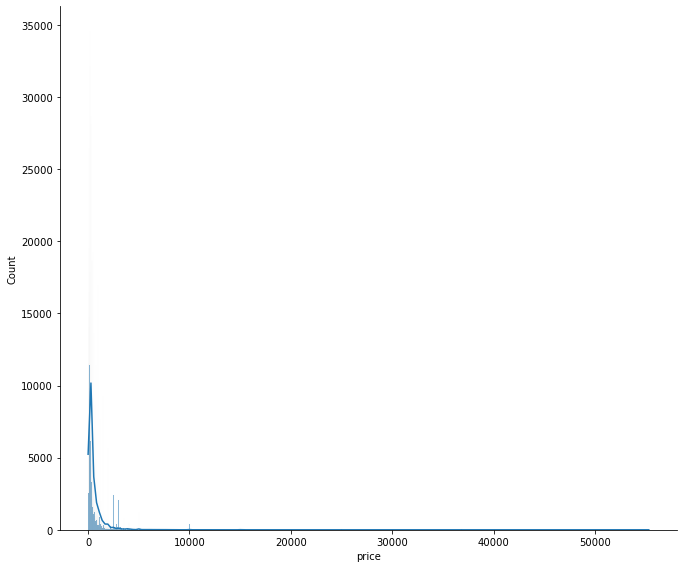

In [16]:
plt.figure(figsize=(12,8))
ax = sns.displot(df['price'],kde=True,height=8, aspect=1.2)


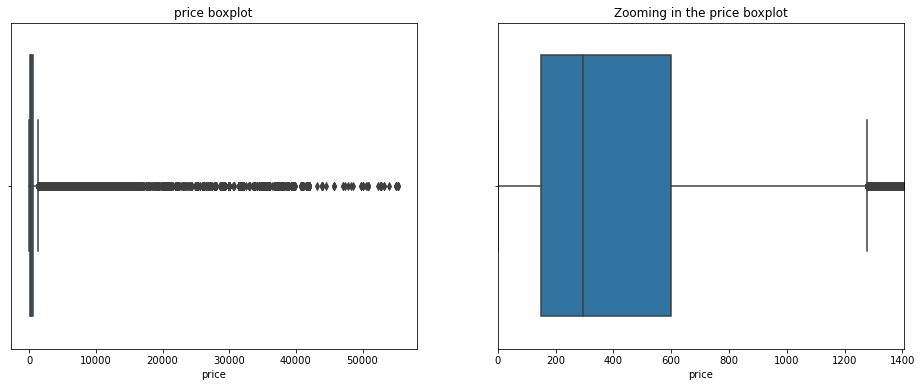

In [17]:
box_plot('price')

In [18]:
df = df[df['price'] <= outlier_limit('price')]

<Figure size 864x576 with 0 Axes>

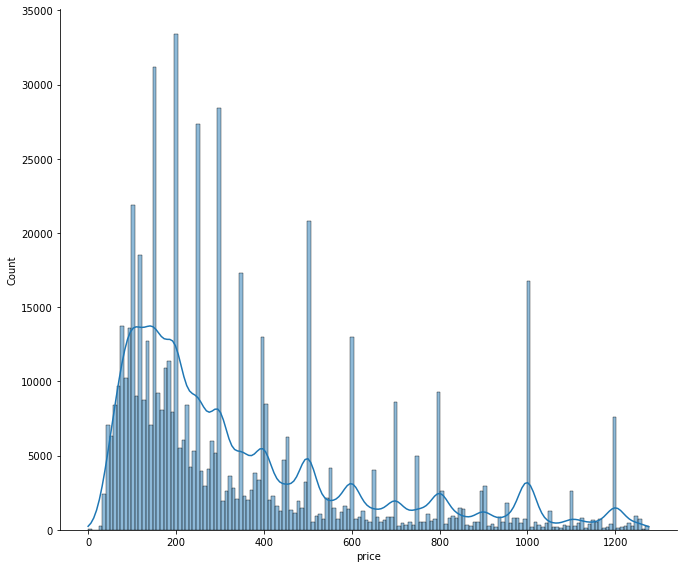

In [19]:
plt.figure(figsize=(12,8))
ax = sns.displot(df['price'],kde=True,height=8, aspect=1.2)

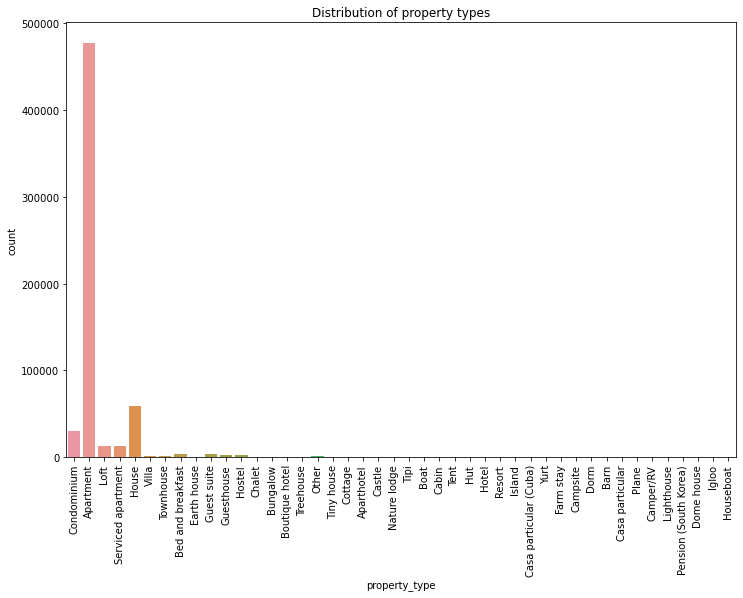

In [20]:
plt.figure(figsize=(12,8))
x = df['property_type']
ax = sns.countplot(x=x, data=df)
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title('Distribution of property types')

In [21]:
categories_to_append = ['Aparthotel', 'Earth house', 'Chalet', 'Cottage', 'Tiny house',
                        'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Bungalow',
                        'Nature lodge', 'Cabin', 'Castle', 'Treehouse', 'Island', 'Boat', 'Tent',
                        'Resort', 'Hut', 'Campsite', 'Barn', 'Dorm', 'Camper/RV', 'Farm stay', 'Yurt',
                        'Tipi', 'Pension (South Korea)', 'Dome house', 'Igloo', 'Casa particular',
                        'Houseboat', 'Lighthouse', 'Plane', 'Train', 'Parking Space']

for cat in categories_to_append:
    df.loc[df['property_type'] == cat, 'property_type'] = 'Other'

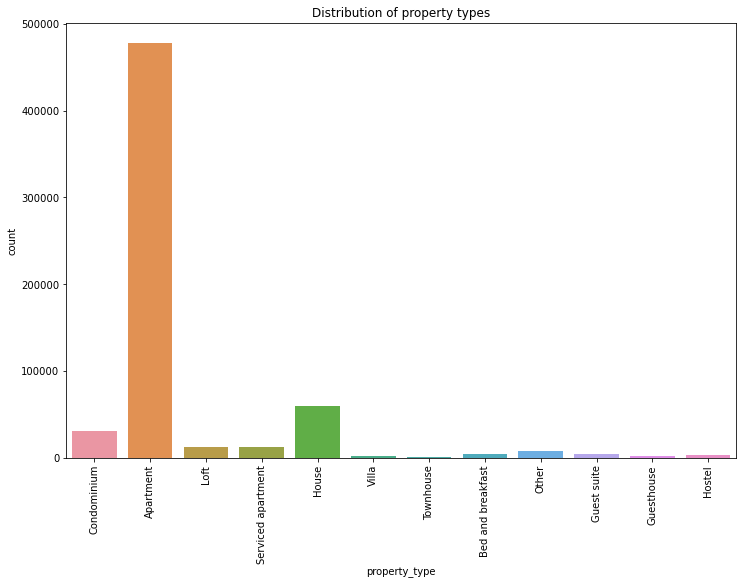

In [22]:
plt.figure(figsize=(12,8))
x = df['property_type']
ax = sns.countplot(x=x, data=df)
ax.tick_params(axis='x', rotation=90)
_ = ax.set_title('Distribution of property types')

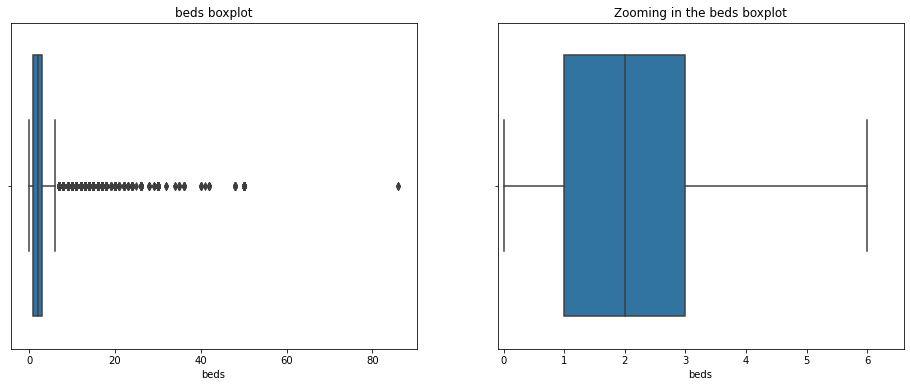

In [23]:
box_plot('beds')

In [24]:
df = df[df['beds'] <= outlier_limit('beds')]

In [25]:
df['amenities'].unique()

array(['{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,"Paid parking off premises","Smoking allowed",Doorman,Elevator,"Hot tub","Family/kid friendly","Suitable for events",Essentials,"24-hour check-in",Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Self check-in","Building staff","Private entrance","Hot water","Bed linens","Luggage dropoff allowed"}',
       '{TV,"Cable TV",Wifi,"Air conditioning","First aid kit",Essentials,Shampoo,Hangers,"Hair dryer",Iron,"Laptop friendly workspace","Hot water","Bed linens","Extra pillows and blankets","Pocket wifi",Microwave,"Coffee maker",Refrigerator,"Dishes and silverware","Beach essentials"}',
       '{TV,"Cable TV",Internet,Wifi,"Air conditioning",Kitchen,Doorman,Elevator,"Buzzer/wireless intercom","Family/kid friendly",Hangers,"Hair dryer",Iron,"Laptop friendly workspace"}',
       ...,
       '{TV,Wifi,"Air conditioning","Free parking on premises","Smoking allowed",Elevator,"Smoke detector","Carbon monoxide detector",Essentia

In [26]:
df['n_amenities'] = df['amenities'].str.split(',').apply(len)+1
df['n_amenities'] = df['n_amenities'].astype('int')
df.loc[df['amenities'] == '{}', 'n_amenities'] = df['n_amenities'].mode()
df = df.drop('amenities', axis=1)

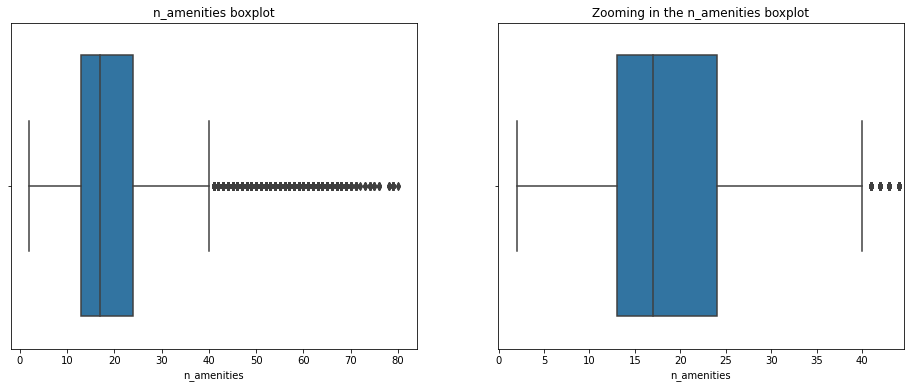

In [27]:
box_plot('n_amenities')

In [28]:
df = df[df['n_amenities'] <= outlier_limit('n_amenities')]

In [29]:
df.head(100)

,host_listings_count,property_type,accommodates,bathrooms,bedrooms,beds,price,month,n_amenities
0,2,Condominium,5,1.0,2.0,2.0,307,8,26.0
1,1,Apartment,2,1.0,1.0,1.0,233,8,21.0
2,3,Apartment,3,1.0,1.0,2.0,159,8,15.0
3,1,Apartment,3,1.0,1.0,2.0,253,8,18.0
4,1,Apartment,3,1.5,1.0,2.0,350,8,32.0
...,...,...,...,...,...,...,...,...,...
149,5,House,3,1.0,1.0,2.0,51,8,6.0
151,1,Condominium,3,2.0,1.0,2.0,253,8,23.0
152,1,Apartment,3,1.0,1.0,1.0,427,8,11.0
153,1,Apartment,5,1.0,2.0,2.0,299,8,15.0


In [30]:
df.drop(['host_listings_count'], axis=1, inplace=True)

In [31]:
df.head(100)

,property_type,accommodates,bedrooms,price,month,n_amenities
0,Condominium,5,2.0,307,8,26.0
1,Apartment,2,1.0,233,8,21.0
2,Apartment,3,1.0,159,8,15.0
3,Apartment,3,1.0,253,8,18.0
4,Apartment,3,1.0,350,8,32.0
...,...,...,...,...,...,...
149,House,3,1.0,51,8,6.0
151,Condominium,3,1.0,253,8,23.0
152,Apartment,3,1.0,427,8,11.0
153,Apartment,5,2.0,299,8,15.0


In [33]:
df.shape


(571888, 6)

In [34]:
cols = list(df)

In [35]:
cols


['property_type', 'accommodates', 'bedrooms', 'price', 'month', 'n_amenities']

In [70]:
df['month'].unique()
if df['property_type'].dtypes == 'object':
    print("yes")

yes


In [ ]:
df2 = df.reindex(['property_type','accommodates','bedrooms','month','n_amenities','price'],axis=1)

In [42]:

class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, var_red=None, value=None):
        ''' constructor ''' 
        
        # for decision node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.var_red = var_red
        
        # for leaf node
        self.value = value

In [43]:
class DecisionTreeRegressor():
    def __init__(self, min_samples_split=2, max_depth=2):
        ''' constructor '''
        
        # initialize the root of the tree 
        self.root = None
        
        # stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        ''' recursive function to build the tree '''
        
        X, Y = dataset[:,:-1], dataset[:,-1]
        num_samples, num_features = np.shape(X)
        best_split = {}
        # split until stopping conditions are met
        if num_samples>=self.min_samples_split and curr_depth<=self.max_depth:
            # find the best split
            best_split = self.get_best_split(dataset, num_samples, num_features)
            # check if information gain is positive
            if best_split["var_red"]>0:
                # recur left
                left_subtree = self.build_tree(best_split["dataset_left"], curr_depth+1)
                # recur right
                right_subtree = self.build_tree(best_split["dataset_right"], curr_depth+1)
                # return decision node
                return Node(best_split["feature_index"], best_split["threshold"], 
                            left_subtree, right_subtree, best_split["var_red"])
        
        # compute leaf node
        leaf_value = self.calculate_leaf_value(Y)
        # return leaf node
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        ''' function to find the best split '''
        
        # dictionary to store the best split
        best_split = {}
        max_var_red = -float("inf")
        # loop over all the features
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            # loop over all the feature values present in the data
            for threshold in possible_thresholds:
                # get current split
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                # check if childs are not null
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    # compute information gain
                    curr_var_red = self.variance_reduction(y, left_y, right_y)
                    # update the best split if needed
                    if curr_var_red>max_var_red:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["var_red"] = curr_var_red
                        max_var_red = curr_var_red
                        
        # return best split
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        #left will be (Condition == true), right will be(condition==false)
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def variance_reduction(self, parent, l_child, r_child):
        #variance reduction is used as this a regression problem. 
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        reduction = np.var(parent) - (weight_l * np.var(l_child) + weight_r * np.var(r_child))
        return reduction
    
    def calculate_leaf_value(self, Y):
        #since these are continuous values we store the mean of the price as the leaf node.
        val = np.mean(Y)
        return val
                
    def print_tree(self, tree=None, indent=" "):
        #prints the tree in preorder traversal. 
        
        if not tree:
            tree = self.root

        if tree.value is not None:
            print(tree.value)

        else:
            print("X_"+str(tree.feature_index), "<=", tree.threshold, "?", tree.var_red)
            print("%sleft:" % (indent), end="")
            self.print_tree(tree.left, indent + indent)
            print("%sright:" % (indent), end="")
            self.print_tree(tree.right, indent + indent)
    
    def fit(self, X, Y):
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def make_prediction(self, x, tree):
        ''' function to predict new dataset '''
        
        if tree.value!=None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val<=tree.threshold:
            return self.make_prediction(x, tree.left)
        else:
            return self.make_prediction(x, tree.right)
    
    def predict(self, X):
        ''' function to predict a single data point '''
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions

In [114]:
#df2.drop(['property_type'], axis=1, inplace=True)
df2.head()
feature_values = df2['bedrooms'].unique()
feature_values[2]


0.0

In [45]:
X = df2.iloc[:, :-1].values
Y = df2.iloc[:, -1].values.reshape(-1,1)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=41)

In [57]:

regressor = DecisionTreeRegressor(min_samples_split=3, max_depth=2)
regressor.fit(X_train,Y_train)
regressor.print_tree()

X_1 <= 1.0 ? 16864.823052567896
 left:X_0 <= 3.0 ? 1318.3812033804788
  left:X_0 <= 1.0 ? 860.5639655638952
    left:154.73334723235692
    right:239.06099638248782
  right:X_3 <= 19.0 ? 1814.8758311033089
    left:340.9023158315033
    right:252.91154268231853
 right:X_1 <= 2.0 ? 3679.5470389895054
  left:X_3 <= 24.0 ? 2953.3052299923584
    left:506.244063421442
    right:373.48432528905096
  right:X_3 <= 24.0 ? 2762.339819645247
    left:639.0338131653921
    right:514.1314027452294


In [58]:
Y_pred = regressor.predict(X_test) 
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y_test, Y_pred))

245.81001291707878

In [59]:
tree1 = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
tree1.fit(X_train,Y_train)
tree1.print_tree()

X_1 <= 1.0 ? 16864.823052567896
 left:X_0 <= 3.0 ? 1318.3812033804788
  left:X_0 <= 1.0 ? 860.5639655638952
    left:X_3 <= 19.0 ? 111.05932795695117
        left:160.46633944251812
        right:135.36138161898964
    right:X_3 <= 26.0 ? 464.108878367093
        left:247.92939992937994
        right:186.72814121717252
  right:X_3 <= 19.0 ? 1814.8758311033089
    left:X_1 <= 0.0 ? 117.28098480174958
        left:313.8668784291077
        right:345.2403623389862
    right:X_3 <= 26.0 ? 629.8776861730075
        left:276.45214727761453
        right:226.1544692340486
 right:X_1 <= 2.0 ? 3679.5470389895054
  left:X_3 <= 24.0 ? 2953.3052299923584
    left:X_0 <= 3.0 ? 1753.3544999308651
        left:376.2537113517134
        right:519.7324067639564
    right:X_3 <= 27.0 ? 904.2005926038546
        left:417.157437567861
        right:352.78049756934513
  right:X_3 <= 24.0 ? 2762.339819645247
    left:X_0 <= 5.0 ? 2880.372048208723
        left:546.1350244681913
        right:670.03929869004

In [60]:
Y_pred = tree1.predict(X_test)
np.sqrt(mean_squared_error(Y_test, Y_pred))

243.78231022176737

In [61]:
df2.drop(['n_amenities'], axis=1, inplace=True)

In [67]:
df2.head()

,accommodates,bedrooms,month,price
0,5,2.0,8,307
1,2,1.0,8,233
2,3,1.0,8,159
3,3,1.0,8,253
4,3,1.0,8,350


In [62]:
X = df2.iloc[:, :-1].values
Y = df2.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=41)

In [63]:
tree2 = DecisionTreeRegressor(min_samples_split=3, max_depth=3)
tree2.fit(X_train,Y_train)
tree2.print_tree()

X_1 <= 1.0 ? 16828.614402433304
 left:X_0 <= 3.0 ? 1327.5191322163882
  left:X_0 <= 1.0 ? 839.3328724079984
    left:X_1 <= 0.0 ? 22.53936834070555
        left:176.83479105928086
        right:154.55615571776156
    right:X_0 <= 2.0 ? 100.82173095826874
        left:233.13362234483316
        right:256.37642666993054
  right:X_1 <= 0.0 ? 70.45834197183285
    left:X_0 <= 5.0 ? 2812.694150718671
        left:270.0005829204314
        right:462.6391585760518
    right:X_0 <= 9.0 ? 153.4499926219505
        left:312.3471379633705
        right:158.88985507246377
 right:X_1 <= 2.0 ? 3727.4475009007438
  left:X_0 <= 3.0 ? 1451.8227513867896
    left:X_0 <= 2.0 ? 2624.0433618628304
        left:290.1622678396872
        right:395.8418246445498
    right:X_0 <= 5.0 ? 28.649596635688795
        left:486.05039199417513
        right:497.89248764832564
  right:X_0 <= 2.0 ? 2361.4786694360373
    left:X_1 <= 4.0 ? 551.5969939783972
        left:253.7680412371134
        right:185.3586956521739
 

In [64]:
Y_pred = tree2.predict(X_test)
np.sqrt(mean_squared_error(Y_test, Y_pred))


246.63553690774677

In [65]:
tree3 = DecisionTreeRegressor(min_samples_split=3, max_depth=2)
tree3.fit(X_train,Y_train)
tree3.print_tree()

X_1 <= 1.0 ? 16828.614402433304
 left:X_0 <= 3.0 ? 1327.5191322163882
  left:X_0 <= 1.0 ? 839.3328724079984
    left:155.61851800361464
    right:238.90393424441086
  right:X_1 <= 0.0 ? 70.45834197183285
    left:285.9164438502674
    right:311.34058329214037
 right:X_1 <= 2.0 ? 3727.4475009007438
  left:X_0 <= 3.0 ? 1451.8227513867896
    left:355.96348210992255
    right:489.43979791631415
  right:X_0 <= 2.0 ? 2361.4786694360373
    left:244.43026706231453
    right:617.1551539526259


In [66]:
Y_pred = tree3.predict(X_test)
np.sqrt(mean_squared_error(Y_test, Y_pred))

247.56430977352338

In [88]:
data = df.reindex(['property_type','accommodates','bedrooms','month','n_amenities','price'],axis=1)

In [89]:
data.head()


,property_type,accommodates,bedrooms,month,n_amenities,price
0,Condominium,5,2.0,8,26.0,307
1,Apartment,2,1.0,8,21.0,233
2,Apartment,3,1.0,8,15.0,159
3,Apartment,3,1.0,8,18.0,253
4,Apartment,3,1.0,8,32.0,350


In [116]:
data = pd.read_csv(r"D:\total_data.csv", index_col=False, usecols=[ 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'amenities', 'month', 'price'])

C:\Users\HK\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (54) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [121]:

data.dtypes

accommodates     object
bathrooms       float64
bedrooms        float64
beds            float64
amenities        object
price           float32
month           float64
dtype: object

In [122]:
data['price'].unique()

array([  307.,   233.,   159., ...,  7186.,  4756., 12096.], dtype=float32)

In [123]:
data['accommodates'] = data['accommodates'].astype(np.int16, copy=False)

In [124]:
data.dtypes

accommodates      int16
bathrooms       float64
bedrooms        float64
beds            float64
amenities        object
price           float32
month           float64
dtype: object

In [125]:
data.drop(['amenities'], axis=1, inplace=True)

In [128]:
data.isnull().sum()


accommodates    0
bathrooms       0
bedrooms        0
beds            0
price           0
month           0
dtype: int64

In [129]:
dataset = data.reindex(['bathrooms','accommodates','bedrooms','month','beds','price'],axis=1)

In [130]:
dataset.head()


,bathrooms,accommodates,bedrooms,month,beds,price
0,1.0,5,2.0,8.0,2.0,307.0
1,1.0,2,1.0,8.0,1.0,233.0
2,1.0,3,1.0,8.0,2.0,159.0
3,1.0,3,1.0,8.0,2.0,253.0
4,1.5,3,1.0,8.0,2.0,350.0


In [135]:
#dataset = dataset[dataset['price'] <= outlier_limit('price')]
#dataset = dataset[dataset['bedrooms'] <= outlier_limit('bedrooms')]

#dataset = dataset[dataset['bathrooms'] <= outlier_limit('bathrooms')]

In [136]:
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.4, random_state=41)

In [137]:
TREE = DecisionTreeRegressor(min_samples_split=3, max_depth=2)
TREE.fit(X_train,Y_train)
TREE.print_tree()

X_2 <= 1.0 ? 8894.554261022917
 left:X_1 <= 1.0 ? 757.8598165406765
  left:X_0 <= 1.0 ? 126.6566725101984
    left:152.10482089954215
    right:125.23720418271877
  right:X_1 <= 3.0 ? 459.250724539299
    left:223.90636079249217
    right:269.1630208537878
 right:X_0 <= 1.5 ? 2002.1708851420553
  left:X_1 <= 3.0 ? 1035.1983954474854
    left:265.75496098104793
    right:369.64026633017426
  right:X_0 <= 2.0 ? 746.888389583306
    left:437.7634086780428
    right:496.7538264468239


In [138]:
Y_pred = TREE.predict(X_test) 
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(Y_test, Y_pred))

188.75334461686515